<a href="https://colab.research.google.com/github/adasegroup/ML2025_seminars/tree/main/Seminar_07/Gaussian_Processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gaussian processes (GP) with GPyTorch**  

Today we will use pytorch-based library [GPyTorch](https://gpytorch.ai/)  for GP modeling.

GPyTorch is a flexible GP framework build upon Pytorch

📅 **Date:** [21/02/2025]  
🏫 **Email/Affiliation: [maria.ivanova@skoltech.ru]**

## **Introduction**  

A **Gaussian Process (GP)** is a powerful probabilistic model used in machine learning for regression and classification tasks. It provides a non-parametric approach to learning distributions over functions, making it particularly useful for modeling uncertainty and making predictions with confidence intervals.  

GPs are defined by a mean function and a covariance function (or kernel), which governs the smoothness and structure of the function space. A common choice is the **Radial Basis Function (RBF) kernel**, which ensures smooth and continuous predictions.  

Gaussian Processes are widely used in **Bayesian optimization**, **spatial data modeling**, and **time-series forecasting** due to their flexibility and ability to quantify uncertainty. However, they can be computationally expensive for large datasets, as they require inverting an $ N \times N $ covariance matrix, where $ N $ is the number of data points.  



## **Contents**  
1- Solving regression task using gaussian processes

2- Regression with GPyTorch. A simple example

3- Real world example, kernals, combining different kernals.

4- Bonus: an advanced example


📌 **Objective:** By the end of this seminar, you will understand Gaussian Processes for regression, learn to implement GPs using GPyTorch, explore real-world examples and kernel combinations.

In [1]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 867.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Solving regression task using gaussian processes
Suppose we have a dataset $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$.  

We assume that:
$$
y = f(x) + \varepsilon,
$$
where $f(x)$ - gaussian process and $\varepsilon \sim 𝒩 (0, \sigma_\varepsilon^2)$ - some gaussing nose.

Posterior distribution of observation $y^*$ at point $x^*$ is gaussian:
$$
y_* | X, \mathbf{y}, x_* \sim 𝒩(m(x_*), \sigma^2(x_*)),
$$
with mean and variance, calculated with equations below:
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
where
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$
$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_\varepsilon^2 \mathbf{I}
$$


### Exercises

1. What the posterior variance at the points from the training set is equal to? What if the noise variance is equal to 0?

2. Suppose that we want to minimize some unknown function $f(\mathbf{x})$.
   We are given a set of observations $y_i = f(\mathbf{x}_i) + \varepsilon_i$, where $\varepsilon_i \sim 𝒩(0, \sigma^2)$.
   Using the observations we built a GP model $\hat{f}(\mathbf{x})$.
   Now, let us consider the value called *improvement*:
   $$
   I(\mathbf{x}) = \max(0, y^* - f(\mathbf{x}))$$
   where $y^*$ is currently found minimum value of $f(\mathbf{x})$.  
   To choose the next candidate for the minimum we would like to maximize the *Expected Improvement*
   $$
       EI(x) = \mathbb{E}_f I(\mathbf{x})
   $$

   1. Express the $EI(\mathbf{x})$ in terms $\Phi(\cdot)$ and $\phi(\cdot)$ - the cdf and pdf of the standard normal distribution $𝒩(0, 1)$.
   2. Assuming $\sigma = 0$ what is the value of $EI(\mathbf{x})$ for any value $y_i$ from the dataset?
   


## Regression with GPyTorch. A simple example
Here we want to model following function:
$$
\begin{align}
y &= \sin(2\pi x) + \varepsilon \\
  \varepsilon &\sim 𝒩(0, 0.04)
\end{align}
$$

with $100$ training, и $51$ testing examples.


In [2]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(
    0.04
)

### Defining GPyTorch model

In order to obtain GP model in GPyTorch we need to define following objects:

1. **GP Model** (`gpytorch.models.ExactGP`) -  Performs predictions.
1. **Likelihood** (`gpytorch.likelihoods.GaussianLikelihood`) - Defines likelihood function for paremeter optimization.
1. **Mean** - Defines a priori mean for $f(x)$.
1. **Kernel** - Defines kernel for covariance matrix computation.
1. **MultivariateNormal** Distribution (`gpytorch.distributions.MultivariateNormal`) - Object, used to defince multivariat gaussian distribution.


In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Working modes

As in most PyTorch modules, `ExactGP` has `.train()` and `.eval()` modes.
- `.train()` mode used during parameter optimization.
- `.eval()` this is used when compution posterior distribution.

### Model training
In following code we will maximize dataset likelihood in order to obtain parameters of kernel and nose

In [5]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
model = ExactGPModel(train_x, train_y, likelihood, covar_module)

In [6]:
def train_model(model, likelihood, train_x, train_y, training_iter=50, verbose=False):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.1
    )  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose:
            print(
                "Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f"
                % (
                    i + 1,
                    training_iter,
                    loss.item(),
                    model.covar_module.base_kernel.lengthscale.item(),
                    model.likelihood.noise.item(),
                )
            )
        optimizer.step()

In [7]:

train_model(model, likelihood, train_x, train_y, training_iter=50, verbose=True)

Iter 1/50 - Loss: 0.927   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.895   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.862   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.825   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.784   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.738   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.689   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.638   lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.590   lengthscale: 0.372   noise: 0.370
Iter 10/50 - Loss: 0.546   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.506   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.468   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.433   lengthscale: 0.272   noise: 0.260
Iter 14/50 - Loss: 0.399   lengthscale: 0.256   noise: 0.237
Iter 15/50 - Loss: 0.366   lengthscale: 0.243   noise: 0.216
Iter 16/50 - Loss: 0.333   lengthscale: 0.233   noise: 0.197
Iter 17/50 - Loss: 0.300   length

### Predictions with GPytorch model

In code below we will perform predictions at new points. To do so, we need to switch model and likelihood into eval mode and call both on test data.

In eval mode GP model returns `MultivariateNormal`, which contains posterior mean and variance.

Let us denote (`test_x`) as `x*`, and target value as `y*`. In this notation `model(test_x)` return posterior on values of function $f$: `p(f* | x*, X, y)`, where `X, y` is training data.

Contrary, `likelihood(model(test_x))` yields posterior predictive distribution of target value `y^*`: `p(y* | x*, X, y)`, which we want to predict.


Predictive mean, variance, as well as, GP posterior function samples at test points can be obtained with following code:

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
```


In [8]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

### Prediction visualization

In [9]:
def plot_model(
    observed_pred, train_x, train_y, test_x, test_x_real=None, test_y_real=None
):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(8, 6))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), ".")
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy())
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        if test_x_real is not None:
            ax.plot(test_x_real, test_y_real, ".", color="tab:green")
            ax.legend(["Observed Data", "Mean", "True", "Confidence"])
        else:
            ax.legend(["Observed Data", "Mean", "Confidence"])
        return ax

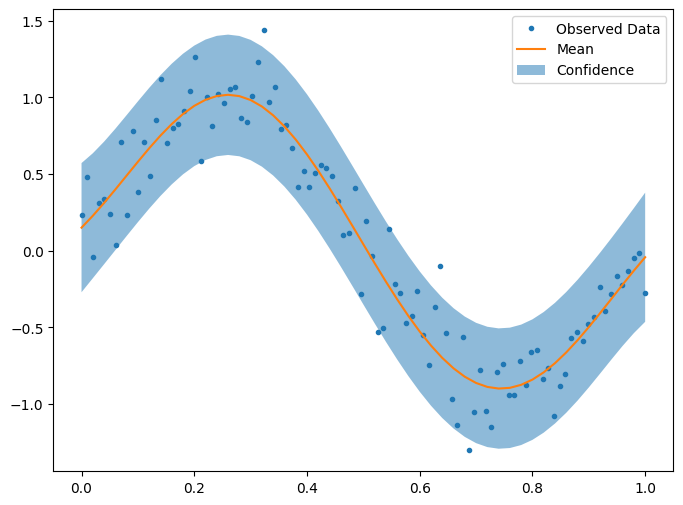

In [10]:
f = plot_model(observed_pred, train_x, train_y, test_x)

## Real world example

Construction of GP model for number of passengers of planes.

In [11]:
!wget https://github.com/adasegroup/ML2020_seminars/raw/master/seminar11/data/airline.npz

--2025-02-21 10:03:18--  https://github.com/adasegroup/ML2020_seminars/raw/master/seminar11/data/airline.npz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adasegroup/ML2020_seminars/master/seminar11/data/airline.npz [following]
--2025-02-21 10:03:19--  https://raw.githubusercontent.com/adasegroup/ML2020_seminars/master/seminar11/data/airline.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2514 (2.5K) [application/octet-stream]
Saving to: ‘airline.npz’

airline.npz         100%[===================>]   2.46K  --.-KB/s    in 0s      

2025-02-21 10:03:19 (29.6 MB/s) - ‘airline.npz’ saved [251

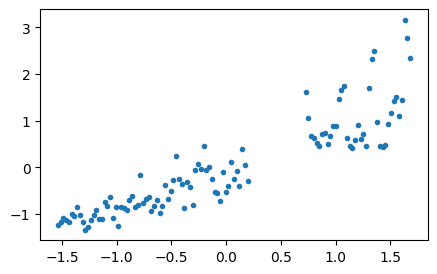

In [ ]:
data = np.load("airline.npz")

X = data["X"][:, 0]
y = data["y"][:, 0]

train_indices = list(range(70)) + list(range(90, 129))
test_indices = range(70, 90)
X_train = X[train_indices]
y_train = y[train_indices]

X_test = X[test_indices]
y_test = y[test_indices]

# normalize data

# mean_x = ...
# std_x = ...

# mean_y =
# std_y =

# X_train =
# y_train =
# X_test =
# y_test =

# your code here

plt.figure(figsize=(5, 3))
plt.plot(X_train, y_train, ".")
plt.show()

In [ ]:
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x_real = torch.tensor(X_test)
test_y_real = torch.tensor(y_test)
test_x = (torch.linspace(1948, 1964, 400, dtype=torch.float32) - mean_x) / std_x

### RBF kernel

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.RBFKernel()
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=50)

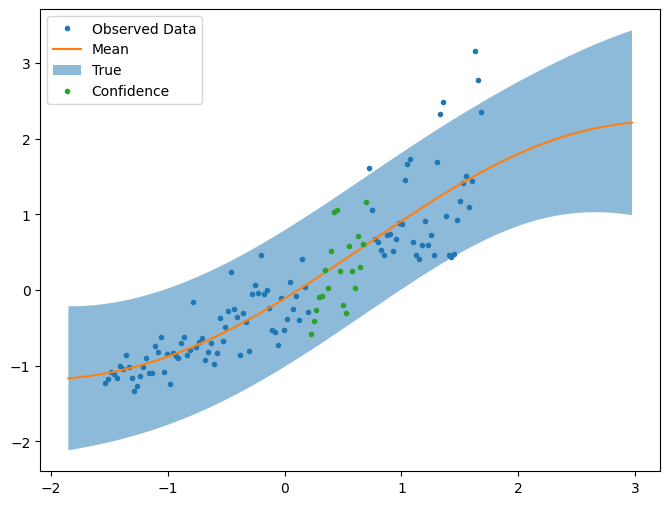

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

### Combining different kernels

Let us combine linear kernel, which picks up on trends, periodic kernel, which notice data seasonality, and RBF kernel, used to capture local nonlinearity.  
For more information see:
https://distill.pub/2019/visual-exploration-gaussian-processes/

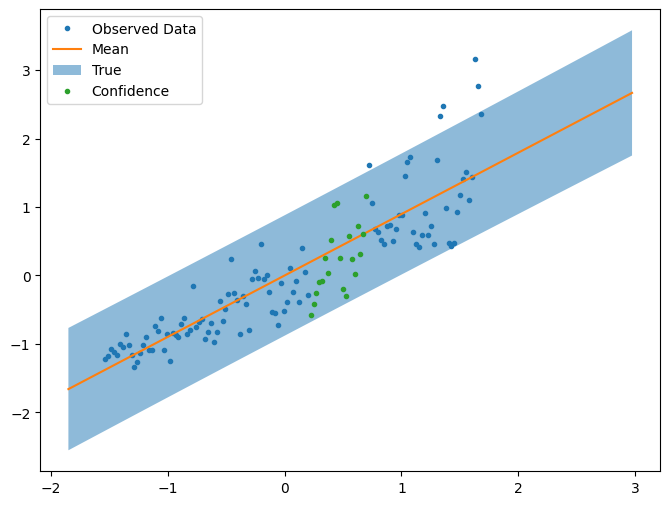

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.LinearKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

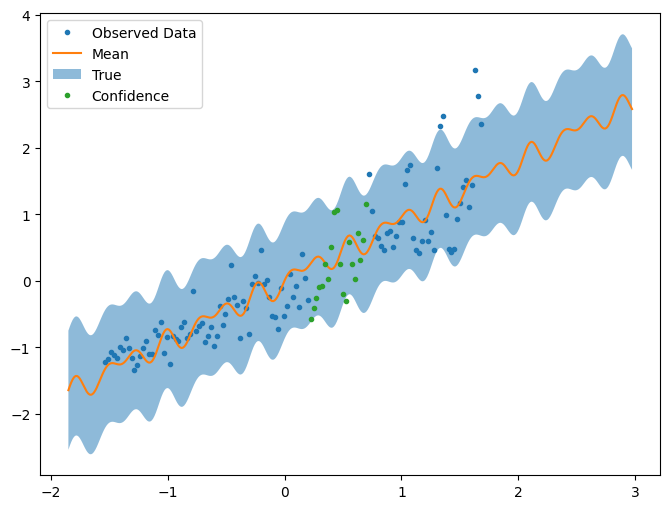

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.LinearKernel() + gpytorch.kernels.PeriodicKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

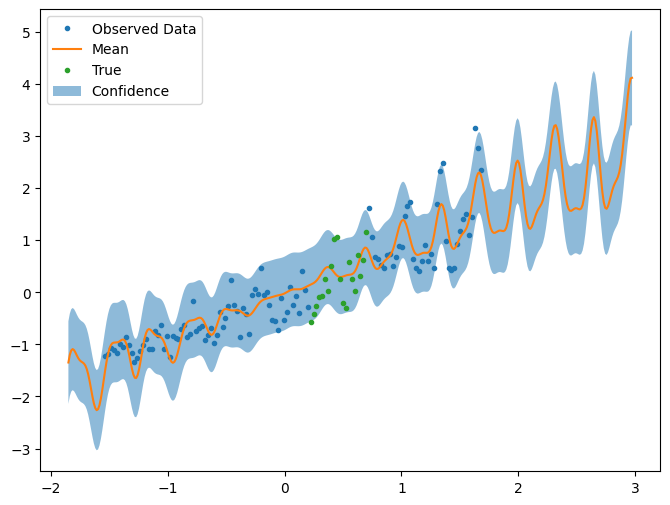

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.LinearKernel() * gpytorch.kernels.PeriodicKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

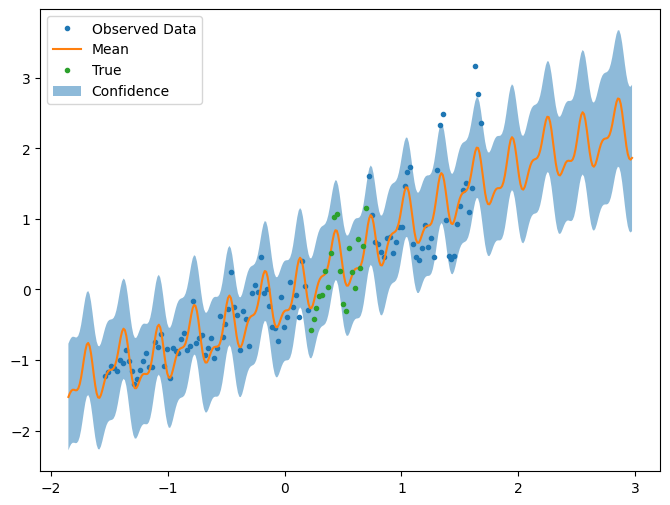

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RBFKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

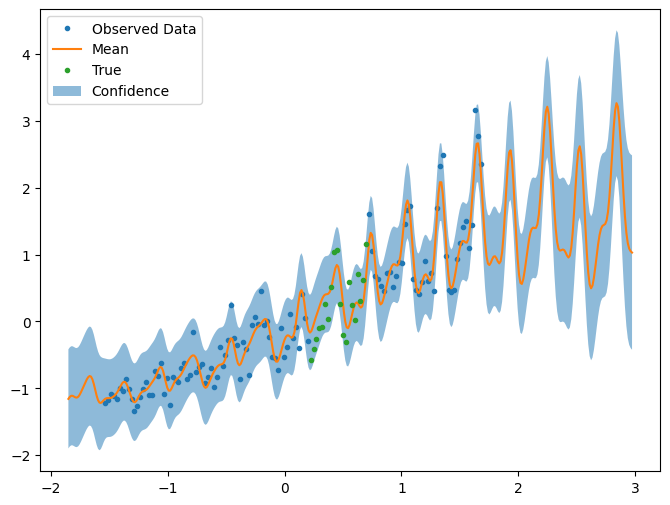

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.PeriodicKernel() * gpytorch.kernels.RBFKernel()
# covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

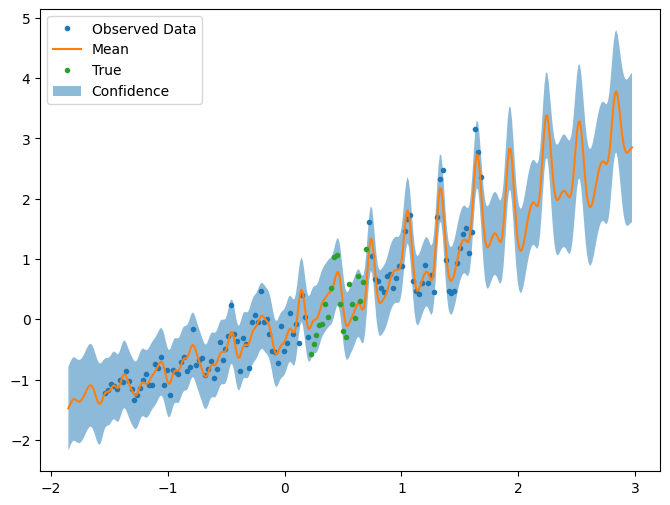

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.LinearKernel() * gpytorch.kernels.RBFKernel()
)
covar_module += gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel() * gpytorch.kernels.RBFKernel()
)
covar_module += gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
covar_module = gpytorch.kernels.ScaleKernel(covar_module)
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=150)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

ax = plot_model(observed_pred, train_x, train_y, test_x, test_x_real, test_y_real)

## Timeseries forcasting. An advanced example

### “Naive” iterative k-step ahead prediction

Consider the discrete time series given by a set $\left\{y_t\right\}$ of samples ordered according to is an integer index $t$, and where the sampling period is constant. Consider as well the state-space model
$$
\left\{\begin{array}{l}
\mathbf{x}_t=\left[y_{t-1}, \ldots, y_{t-\mathcal{L}}\right]^{\top} \\
y_t=f\left(\mathbf{x}_t\right)+\epsilon
\end{array}\right.
$$
where the state $\mathbf{x}$ at time $t$ is composed of previous outputs, up to a given $\operatorname{lag} \mathcal{L}$ and we have an additive (white) noise with variance $\sigma_\epsilon^2$.

The naive iterative $k$-step ahead prediction method works as follows: it predicts only one time step ahead, using the estimate of the output of the current prediction, as well as previous outputs (up to the lag $\mathcal{L}$ ), as the input to the prediction of the next time step, until the prediction $k$ steps ahead is made.
Assuming the data is known up to time step $T$, the prediction of $y_{T+k}$ is computed via
$$
\begin{aligned}
& \mathbf{x}_{T+1}=\left[y_T, y_{T-1}, \ldots, y_{T+1-\mathcal{L}}\right]^{\top} \rightarrow f\left(\mathbf{x}_{T+1}\right) \sim \mathcal{N}\left(\mu\left(\mathbf{x}_{T+1}\right), \sigma^2\left(\mathbf{x}_{T+1}\right)\right) \\
& \hat{y}_{T+1}=\mu\left(\mathbf{x}_{T+1}\right) \\
& \mathbf{x}_{T+2}=\left[\hat{y}_{T+1}, y_t, \ldots, y_{T+2-\mathcal{L}}\right]^{\top} \rightarrow f\left(\mathbf{x}_{T+2}\right) \sim \mathcal{N}\left(\mu\left(\mathbf{x}_{T+2}\right), \sigma^2\left(\mathbf{x}_{T+2}\right)\right) \\
& \hat{y}_{T+2}=\mu\left(\mathbf{x}_{T+2}\right) \\
& \mathbf{x}_{T+k}=\left[\hat{y}_{T+k-1}, \hat{y}_{T+k-2}, \ldots, \hat{y}_{T+k-\mathcal{L}}\right]^{\top} \rightarrow f\left(\mathbf{x}_{T+k}\right) \sim \mathcal{N}\left(\mu\left(\mathbf{x}_{T+k}\right), \sigma^2\left(\mathbf{x}_{T+k}\right)\right) \\
& \hat{y}_{T+k}=\mu\left(\mathbf{x}_{T+k}\right) \\
&
\end{aligned}
$$

### Propagating the uncertainty

Suppose as before, that data samples have been observed up to time $T$, we call $Y_T$ the set observed samples up to that time, and we wish to predict $k$ steps ahead. The predictive distribution we want to compute is
$$
p\left(y_{T+k} \mid Y_T\right)=\int p\left(y_{T+k} \mid \mathbf{x}_{T+k}\right) p\left(\mathbf{x}_{T+k} \mid Y_T\right), d \mathbf{x}_{T+k} .
$$

The problem is that the distribution of the state at time $t=T+k, p\left(\mathbf{x}_{T+k} \mid Y_T\right)$, does depend on the distribution of the output at the previous time $t=T+K-1, p\left(y_{T+k-1} \mid Y_T\right)$ since the random variable $y_{T+k-1}$ is incorporated in the state $\mathbf{x}_{T+k}$. We thus need a recursive algorithm.

#### Prediction at $\mathrm{x}^* \sim \mathcal{N}(\mathrm{u}, \mathrm{S})$
The predictive distribution of the function value, $p\left(f^*\right)$ (we will for simplicity write from now on $f^*=f\left(\mathbf{x}^*\right)$ ), when the input is the random variable $\mathbf{x}^*$ with input distribution given by $p\left(\mathbf{x}^* \mid \mathbf{u}, \mathbf{S}\right) \sim \mathcal{N}(\mathbf{u}, \mathbf{S})$, is obtained by integrating over the input distribution:
$$
p\left(f^* \mid \mathbf{u}, \mathbf{S}, \mathcal{D}\right)=\int p\left(f^* \mid \mathbf{x}^*, \mathcal{D}\right) p\left(\mathbf{x}^* \mid \mathbf{u}, \mathbf{S}\right) d \mathbf{x}^*,
$$
where $p\left(f^* \mid \mathbf{x}^*\right)=\frac{1}{\sigma\left(\mathrm{x}^*\right) \sqrt{2 \pi}} \exp \left[-\frac{1}{2} \frac{\left(f^*-\mu\left(\mathrm{x}^*\right)\right)^2}{\sigma^2\left(\mathrm{x}^*\right)}\right]$ with mean and variance depending on the model.

For more details see https://mlg.eng.cam.ac.uk/pub/pdf/QuiGirRas03.pdf

### Example of Timeseries forcasting with uncertain inputs

In [ ]:
from makey_glass import mackey_glass, MackeyGlassDataset
from gpr import GPRModel
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
from uncertain_input_model import GPRUncInputs

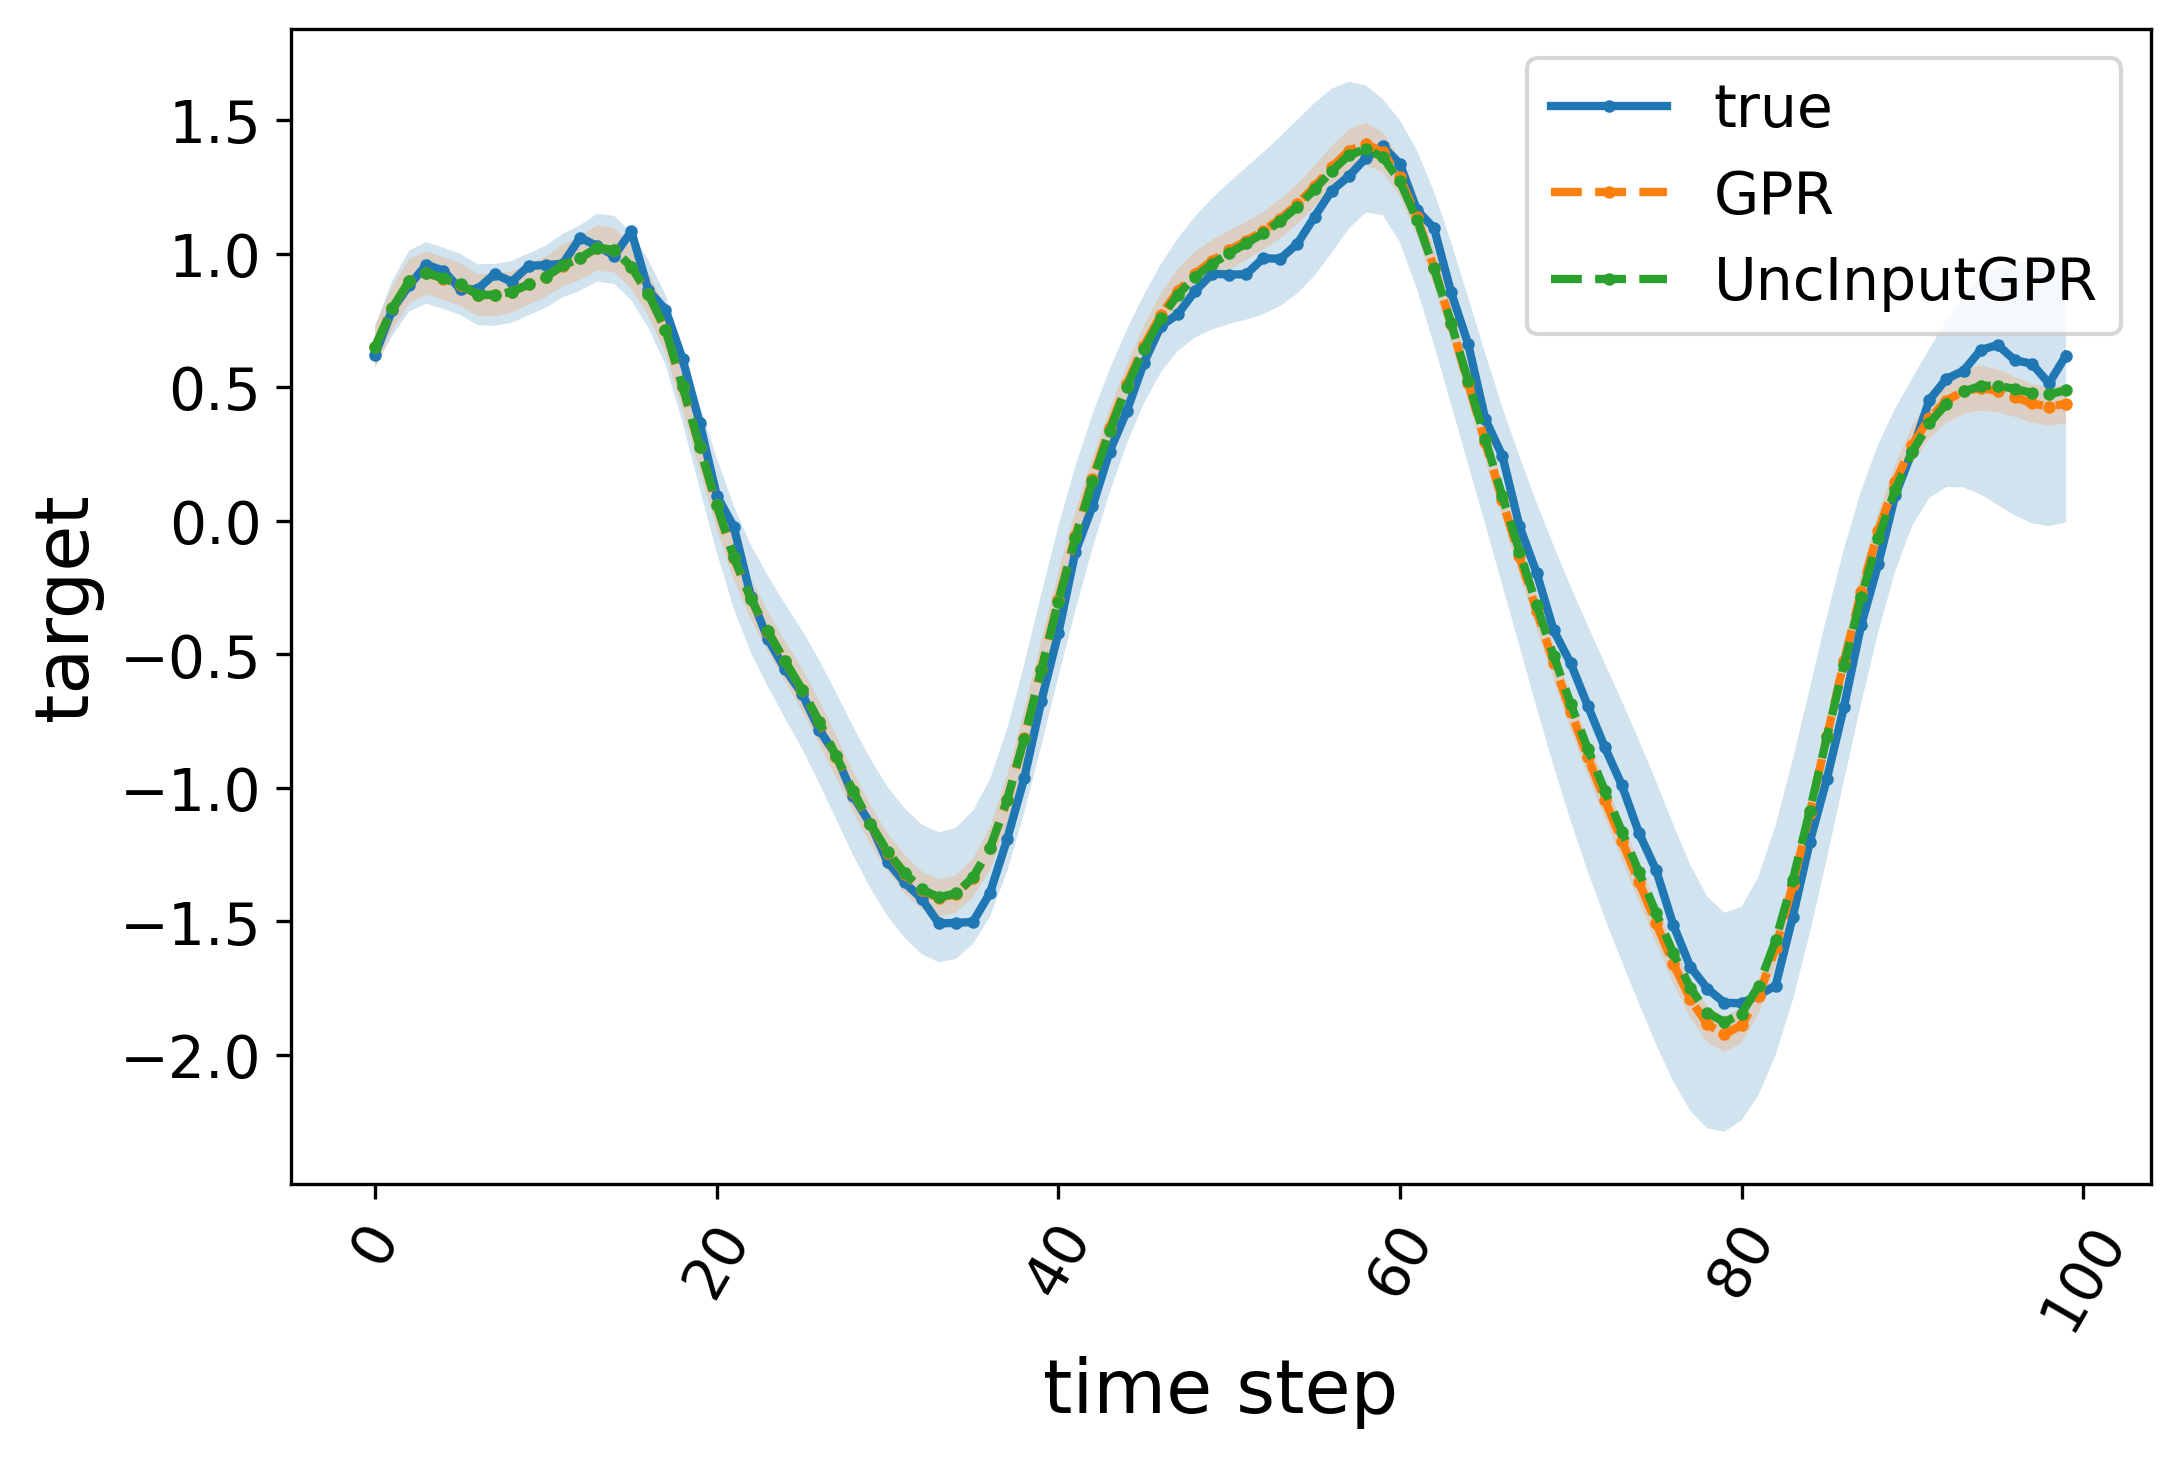

In [ ]:
L = 50
nose_std = (0.001) ** 0.5
seed = 7
makey_train_ds = MackeyGlassDataset(
    length=8000, size=100, L=L, seed=seed, nose_std=nose_std
)
# create test point

rs = RandomState(seed)
n = 170
x0 = 0.5 + 0.05 * (-1 + 2 * rs.random(n))
x = mackey_glass(length=100 + L, tau=17.0, sample=1.0, n=n, x0=x0)
test_points = (x - makey_train_ds.mean) / makey_train_ds.std
test_points += rs.normal(0, nose_std, size=len(test_points))

gpr_model = GPRModel(normalize_data=False, training_iter=500, use_scale=False)

x_train = makey_train_ds.train_set_x
y_train = makey_train_ds.train_set_y

# fit
gpr_model.fit(np.flip(x_train, 1).copy(), y_train)

# test unc model
model = GPRUncInputs(gpr_model, test_points[:L][::-1].copy())
predictions = []
stds = []
for i in range(len(test_points) - L):
    next_x, next_std = model.predict_with_unc_inputs()
    predictions.append(next_x)
    stds.append(next_std)

predictions = np.array(predictions)
stds = np.array(stds)
val_low = predictions - 2 * stds
val_high = predictions + 2 * stds

# predict gpr
predictions_gpr = []
stds_gpr = []
x_test = test_points[:L][::-1].tolist()
for i in range(len(test_points) - L):
    next_x, next_std = gpr_model.predict(np.array(x_test)[np.newaxis, :])
    predictions_gpr.append(next_x[0])
    stds_gpr.append(next_std[0])
    x_test = [next_x[0]] + x_test[:-1]

predictions_gpr = np.array(predictions_gpr)
stds_gpr = np.array(stds_gpr)
val_low_gpr = predictions_gpr - 2 * stds_gpr
val_high_gpr = predictions_gpr + 2 * stds_gpr

plt.figure(figsize=(8, 5), dpi=300)
time_future = np.arange(len(test_points) - L)
plt.plot(
    time_future,
    test_points[L:],
    label="true",
    linewidth=2,
    linestyle="-",
    marker="o",
    markersize=2,
)
plt.plot(
    time_future,
    predictions_gpr,
    label="GPR",
    linewidth=2,
    linestyle="--",
    marker="o",
    markersize=2,
)
plt.plot(
    time_future,
    predictions,
    label="UncInputGPR",
    linewidth=2,
    linestyle="--",
    marker="o",
    markersize=2,
)

plt.fill_between(time_future, val_low, val_high, alpha=0.2)
plt.fill_between(time_future, val_low_gpr, val_high_gpr, alpha=0.2)

plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14)
plt.xlabel("time step", fontsize=18)
plt.ylabel("target", fontsize=18)
plt.legend(fontsize=14)
# plt.show()
plt.savefig("./test.png")